<a href="https://colab.research.google.com/github/cwattsnogueira/rating-predictor-spam-detection-review-summarizer/blob/main/bert_5class_rating_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install transformers datasets scikit-learn joblib --quiet

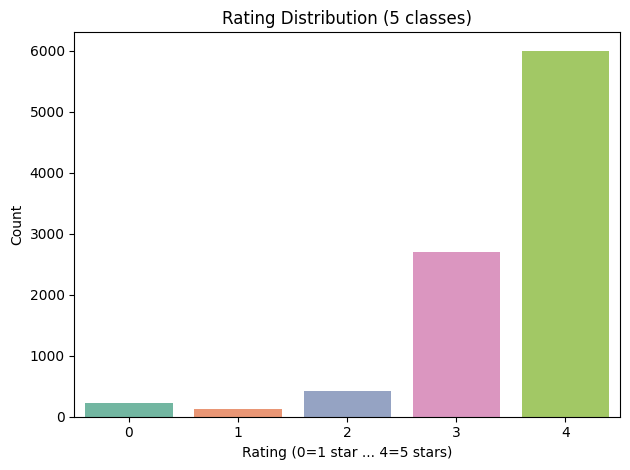

Class Weights: [ 8.35242291 14.58461538  4.46117647  0.70300334  0.31594734]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/7584 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 0: 100%|██████████| 474/474 [00:40<00:00, 11.64it/s, train_loss=1.77]


Epoch 0 - Validation Loss: 1.3025 - Accuracy: 0.5295


Epoch 1: 100%|██████████| 474/474 [00:39<00:00, 12.00it/s, train_loss=1.29]


Epoch 1 - Validation Loss: 1.2253 - Accuracy: 0.5649


Epoch 2: 100%|██████████| 474/474 [00:39<00:00, 11.97it/s, train_loss=1.38]


Epoch 2 - Validation Loss: 1.4154 - Accuracy: 0.5997


Epoch 3: 100%|██████████| 474/474 [00:39<00:00, 11.97it/s, train_loss=1.23]


Epoch 3 - Validation Loss: 1.6669 - Accuracy: 0.6403
Early stopping triggered.
              precision    recall  f1-score   support

           0     0.3784    0.8000    0.5138        35
           1     0.0938    0.1667    0.1200        18
           2     0.2571    0.1935    0.2209        93
           3     0.3980    0.6586    0.4962       539
           4     0.8056    0.5508    0.6542      1211

    accuracy                         0.5649      1896
   macro avg     0.3866    0.4739    0.4010      1896
weighted avg     0.6481    0.5649    0.5804      1896



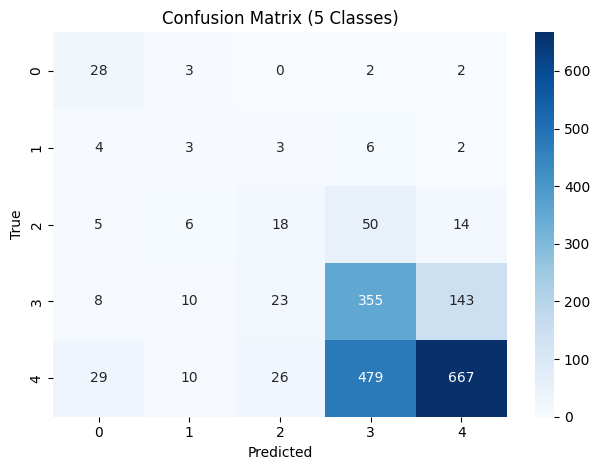

Accuracy for Class 0 (1 stars): 80.00%
Accuracy for Class 1 (2 stars): 16.67%
Accuracy for Class 2 (3 stars): 19.35%
Accuracy for Class 3 (4 stars): 65.86%
Accuracy for Class 4 (5 stars): 55.08%


('bert_5class_rating_model/tokenizer_config.json',
 'bert_5class_rating_model/special_tokens_map.json',
 'bert_5class_rating_model/vocab.txt',
 'bert_5class_rating_model/added_tokens.json')

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from datasets import Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from torch.nn.functional import softmax
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned review data
df = pd.read_parquet("/content/engineered_features.parquet")
df = df[['clean_text', 'reviews.rating']].dropna()

# Keep original 5-star labels (1–5)
df['label'] = df['reviews.rating'].astype(int) - 1  # labels must be 0–4 for PyTorch

sns.countplot(x='label', hue='label', data=df, palette='Set2', legend=False)
plt.title("Rating Distribution (5 classes)")
plt.xlabel("Rating (0=1 star ... 4=5 stars)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Compute class weights for imbalance
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df['label']),
                                     y=df['label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print("Class Weights:", class_weights)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = Dataset.from_pandas(df[['clean_text', 'label']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

def tokenize_function(example):
    return tokenizer(example['clean_text'], truncation=True, padding='max_length', max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset['test'], batch_size=16)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_epochs * len(train_dataloader))

# Weighted loss
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

best_val_loss = float('inf')
patience = 2
counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loop = tqdm(train_dataloader, leave=True)
    for batch in train_loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['label'])
        loss = loss_fn(outputs.logits, batch['label'])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_loop.set_description(f"Epoch {epoch}")
        train_loop.set_postfix(train_loss=loss.item())

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['label'])
            loss = loss_fn(outputs.logits, batch['label'])
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch['label'].cpu().numpy())

    avg_val_loss = val_loss / len(eval_dataloader)
    val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
    print(f"Epoch {epoch} - Validation Loss: {avg_val_loss:.4f} - Accuracy: {val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_multiclass_rating_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load("best_multiclass_rating_model.pt"))
model.eval()

# Evaluation
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'])
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['label'].cpu().numpy())

# Classification report (macro F1 handles imbalance better)
report = classification_report(all_labels, all_preds, zero_division=0, output_dict=True, digits=4)
print(classification_report(all_labels, all_preds, zero_division=0, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (5 Classes)")
plt.tight_layout()
plt.show()

# Per-class accuracy
for i in range(5):
    correct = np.sum((np.array(all_labels) == i) & (np.array(all_preds) == i))
    total = np.sum(np.array(all_labels) == i)
    acc = correct / total if total > 0 else 0
    print(f"Accuracy for Class {i} ({i+1} stars): {acc:.2%}")

# Save metrics + model
joblib.dump({
    "classification_report": report,
    "confusion_matrix": cm.tolist(),
    "class_weights": class_weights.tolist()
}, "bert_5class_rating_metrics.pkl")

torch.save(model.state_dict(), "final_5class_rating_model.pt")
model.save_pretrained("bert_5class_rating_model")
tokenizer.save_pretrained("bert_5class_rating_model")